<a href="https://www.kaggle.com/code/chakrabortyarnab/image-generation-using-auto-encoders?scriptVersionId=120429756" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv


# Introduction to Autoencoders
**Autoencoders** are a type of neural network used for unsupervised learning that aim to learn a compressed representation of an input data by training a neural network to reconstruct the original data from a lower-dimensional encoding, called the **latent space**. 

The basic structure of an autoencoder consists of two main components: an encoder and a decoder.
- The encoder part of the network maps the input data to a lower-dimensional latent representation, which contains compressed information about the input data 
- The decoder part of the network then maps the latent representation back to the original input data, generating a reconstruction of the input

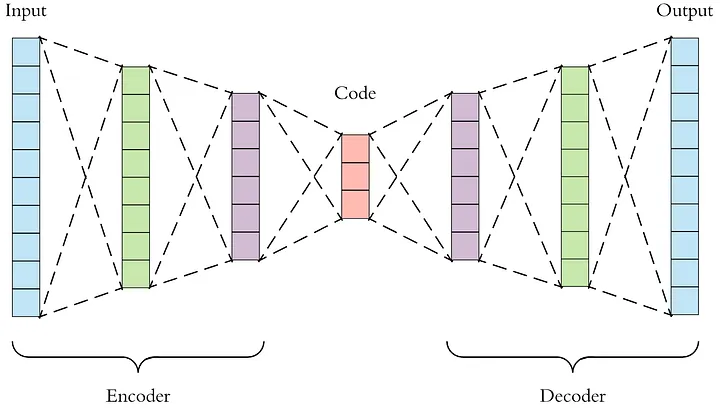

The middle latent vector is a compressed representation of the input. It can also be used to reproduce variations. There are numerous applications, such as:
- Dimensionality Reduction/ Compression
- Training data augmentation
- Data Denoising
- Anomaly Detection

### Installing Keras
Keras is a high-level neural network API, written in Python which runs on top of either Tensorflow or Theano. You can install Keras from [here](http://keras.io/#installation).

Keras was written to simplify the construction of neural nets, as tensorflow’s API is very verbose. Keras makes everything very easy and you will see it in action below.

In [2]:
#importing 
from keras.models import Model
from keras.layers import *
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Problem Statement
Our goal is to train AutoEncoders on thousands of MNIST style images the following 94 alphabetic characters and use them to regenerate these images:

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\', ']', '^', '_', '`', '{', '|', '}', '~'}

This dataset contains over 281,000 images and is part of the Warhol.ai Computational Creativity and Cognitive Type projects.

We will use the Keras Python API with TensorFlow as the backend.

In [3]:
#reading the dataset
df=pd.read_csv('/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv')
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Removing names and labels
X=df.drop(['names','labels'],axis=1)
y=df['labels']

In [5]:
#Creating a train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

output_X_train = X_train.values.reshape(-1,28,28,1)
output_X_test = X_test.values.reshape(-1,28,28,1)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (219274, 784)
219274 train samples
54819 test samples


# Defining the Architecture

In [6]:
#encoder
encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(32, activation = 'relu')(flat)

In [7]:
#decoder
dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

#AE
autoencoder = Model(encoder_inputs, decoded_outputs)

# Fitting the model

In [8]:
m = 256
n_epoch = 10
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, batch_size=m, shuffle=True)

Epoch 1/10
857/857 [==============================] - 16s 10ms/step - loss: 0.2070
Epoch 2/10
857/857 [==============================] - 8s 9ms/step - loss: 0.1518
Epoch 3/10
857/857 [==============================] - 8s 10ms/step - loss: 0.1526
Epoch 4/10
857/857 [==============================] - 8s 9ms/step - loss: 0.1457
Epoch 5/10
857/857 [==============================] - 8s 9ms/step - loss: 0.1421
Epoch 6/10
857/857 [==============================] - 8s 9ms/step - loss: 0.1364
Epoch 7/10
857/857 [==============================] - 8s 10ms/step - loss: 0.1405
Epoch 8/10
857/857 [==============================] - 8s 9ms/step - loss: 0.1237
Epoch 9/10
857/857 [==============================] - 8s 10ms/step - loss: 0.1250
Epoch 10/10
857/857 [==============================] - 8s 10ms/step - loss: 0.1236


# Predicting on test dataset

In [9]:
test_imgs = autoencoder.predict(output_X_test)
print(test_imgs.shape)

1714/1714 [==============================] - 4s 2ms/step
(54819, 28, 28, 1)


# Let's check the results

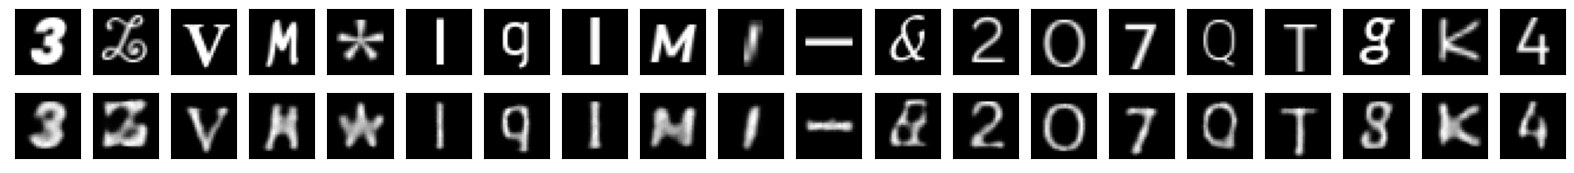

In [10]:
n = 20  # how many digits we will display
plt.figure(figsize=(20, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(output_X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Observation**:
* We can simply see the performance of AutoEncoder after 10 Epochs of training.
* Despite the fact that some details are still missing, the general shape can be generated, and the feature points are mostly there. 

# Conclusion

Autoencoders have proven to be a powerful tool for image generation tasks. By training an autoencoder on a dataset of images, it is possible to learn a **mpressed representation** of the image, which can be used to generate new images that are similar to those in the training set. This technique has been used to generate a wide range of images, including faces, landscapes, and even abstract art.

One of the main advantages of using autoencoders for image generation is their ability to capture the underlying structure of the data, which can be used to create new and interesting variations on the original images. Additionally, because autoencoders can learn a compressed representation of the data, they are much more efficient than other generative models, such as generative adversarial networks (GANs), which can require large amounts of training data and computational resources.

Overall, autoencoders have proven to be a **versatile and effective tool** for image generation, and are likely to continue to be an important area of research in the field of computer vision and machine learning.